# Pandas
Pandas (Python Data Analysis Library) is a swiss-army knife module you'll find at the top of a huge proportion of datascience notebooks. It's popular enough to deserve its own import idiom...

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = (16, 12)

To get a quick idea of the scope of pandas take a look at the autocomplete for pd.

The fundamental objects in pandas are the `Series` and the `DataFrame`. Together they encapsulate how you will normally ingest, clean, manipulate and even visualize external data sources. Most of this module will use methods on these objects so we'll take a quick tour of the concepts they implement, and the idea of an `index`.

## Series
The pandas `Series` object is basically a one dimensional indexed array. Schematically, it looks like

| Index | Value |
|-------|-------|
| 0     |  0.12 |
| 1     |  0.24 |
| 2     |  0.36 |
| 3     |  0.48 |

Where there are two columns: an index and a value. Most of the time the index values are distinct (not a firm requirement though!) but they don't have to be integers; any hashable type will do

In [3]:
s1 = pd.Series({'one' : 1.0, 'two': 2.0, 'three': 3.0})
s1

one      1.0
two      2.0
three    3.0
dtype: float64

One particularly common option is to use a timestamp as the index (don't worry about the syntax here, we'll come back to time-series later)...

In [4]:
dti = pd.date_range('2020-06-03', periods=3, freq='H')
pd.Series(['first', 'second', 'third'], index=dti)

2020-06-03 00:00:00     first
2020-06-03 01:00:00    second
2020-06-03 02:00:00     third
Freq: H, dtype: object

The next thing to notice is that the values all have the same type (e.g. `dtype: float64` for `s1`). `pandas` can make `Series` of almost any type as long as all the rows share the same type, but it will try to pick the most efficient implementation (`ndarrays` for numeric types). It can fall back to a generic `object` type if all else fails but it really pays (in speed) to keep an eye on the `dtype` and make it a `numpy` type where possible.

In [5]:
s2 = pd.Series(['one', 2, 'three'])
s2

0      one
1        2
2    three
dtype: object

### Making `Series`

You'll probably find that you are making `DataFrames` more often than `Series`, but lots of operations in `panadas` return Series, or want them as an argument so it's good to know how to build them.

Like `ndarray`'s, you can initialize a `Series` from a sequence, it'll get the default ascending integer index

In [6]:
sf = pd.Series([1.0, 2.0, 3.0, 4.0, 5.0])
sf

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
dtype: float64

In [7]:
si = pd.Series(range(5))
si

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [8]:
si.dtype

dtype('int64')

So far, this looks a lot like a numpy array (or even just a list), but we can switch the indexing to suit our needs, by explicitly passing the `index=` arguement

In [9]:
sm = pd.Series([1., 2., 3., 4., 5.], index=['one', 'two', 'three', 'four', 'five'])
sm

one      1.0
two      2.0
three    3.0
four     4.0
five     5.0
dtype: float64

### Indexing and Slicing

square bracket notation will select by index value, this is convenient (but see `.loc` and `.iloc` later for more flexibility)

In [10]:
sm['three']

3.0

Now the series is starting to look more like a dictionary, in fact, that's another good way to construct `Series`

In [11]:
sn = pd.Series({'one': 1, 'three': 3, 'two': 2, 'four': 4, 'five': 5})
sn

one      1
three    3
two      2
four     4
five     5
dtype: int64

When you look closely though, a Series has a few tricks that a dictionary doesn't...

In [12]:
sn['three':'four']

three    3
two      2
four     4
dtype: int64

N.B. label based indexes are _inclusive_ of the `stop` value. This is different from most other slices you'll see in python, but this can cause a little confusion. Basically it boils down to the idea that there isn't always a natural "next" object in a hash (notice that the rows aren't sorted beyond what we specified manually in the index).

If you use numbers to do the slice, you'll get the familiar python behaviour


In [13]:
sn[1:3]

three    3
two      2
dtype: int64

Series have a `keys()` method, but it returns an index object

In [14]:
sn.keys()

Index(['one', 'three', 'two', 'four', 'five'], dtype='object')

Element by element statements evaluate to Booleans

In [15]:
sn > 2

one      False
three     True
two      False
four      True
five      True
dtype: bool

and if you remember the material on numpy fancy indexing, this can be very useful

In [16]:
sn[sn > 2]

three    3
four     4
five     5
dtype: int64

There are also some extra indexing methods available to you: `.loc`, `.iloc`, `.ix`. We'll discuss these more in the context of `DataFrames`, but basically they let you be much more explicit about exactly what you want to return. At a very basic level, they can help you avoid label confusion...

In [17]:
sa = pd.Series(data=['apple', 'banana', 'orange', 'pineapple'], index=[3, 2, 1, 7])

sa

3        apple
2       banana
1       orange
7    pineapple
dtype: object

Suppose we want the value in the 4th row...

In [18]:
sa[3]

'apple'

Nope, `3` was interperted as a label. There's an ambiguity because of the type of the index. Fortunately `pandas` gives us a pair of functions to avoid that problem

  * `.iloc[]`: Purely integer-location based indexing.
  * `.loc[]` : Purely label based indexing.

In [19]:
sa.loc[3]

'apple'

In [20]:
sa.iloc[3]

'pineapple'

And `.iloc` will also work with slices

In [21]:
sa.iloc[:3:2]

3     apple
1    orange
dtype: object

Logical and fancy indexing work here too

In [22]:
sa.iloc[[2, 1, 3]]

1       orange
2       banana
7    pineapple
dtype: object

Logical indexing works with these methods as well...

In [23]:
sn.loc[sn>3]

four    4
five    5
dtype: int64

## DataFrames

Most of the time you will be using `DataFrames` rather than `Series`, but at a first pass it is OK to think of `DataFrames` as a bunch of `Series` stuck together with a common index. 


| Index | Value1 | Value2 | 
|-------|--------|--------|
|   0   |  0.12  |   'a'  |
|   1   |  0.24  |   'b'  |
|   2   |  0.36  |   'c'  |
|   3   |  0.48  |   'd'  |

The rules discussed above for the index stay the same but notice that we can now have different types in the various columns

In [24]:
d1 = pd.DataFrame({'floats': sm, 'ints': sn})
d1

,floats,ints
five,5.0,5
four,4.0,4
one,1.0,1
three,3.0,3
two,2.0,2


In [25]:
d1.dtypes

floats    float64
ints        int64
dtype: object

### DataFrame Attributes

We've already seen some of the attributes of the DataFrame (column etc.) but there are quite a few available, take a look at `dtypes`, `ndim`, `shape`

In [26]:
d1.index

Index(['five', 'four', 'one', 'three', 'two'], dtype='object')

In [27]:
d1.columns

Index(['floats', 'ints'], dtype='object')

In [28]:
d1.shape

(5, 2)

In [29]:
d1.dtypes

floats    float64
ints        int64
dtype: object

### Indexing

When indexing a dataframe, the default is to give you the column (you can also use the syntax `d1.ints`)

In [30]:
d1['ints']


five     5
four     4
one      1
three    3
two      2
Name: ints, dtype: int64

If you are looking for the row, then try `.loc` with the row index value

In [31]:
d1.loc['one']

floats    1.0
ints      1.0
Name: one, dtype: float64

In fact, you probably want to lean towards `.loc` when you want to subset rows and/or columns. It is much more flexible and helps pandas resolve some potential ambiguities about what you want to select. Here is a column selection...

In [32]:
d1.loc['four':'three', ['ints']]

,ints
four,4
one,1
three,3


(The square brackets around 'ints' here tell pandas I want a `DataFrame` to be returned, rather than a `Series`)

In [33]:
d1.iloc[:2]

,floats,ints
five,5.0,5
four,4.0,4


In [34]:
# `.iloc` will interprete both row and column specifiers as numerical positions
d1.iloc[:2, 1]

five    5
four    4
Name: ints, dtype: int64

Logical/fancy indexing works with `.loc` and `.iloc` as well, but remember the parentheses or `&` will be interpreted as a bitwise operator.

In [35]:
d1.loc[(d1['ints'] > 2) & (d1['floats'] < 4), ['ints', 'floats']]

,ints,floats
three,3,3.0


Wherever possible, `pandas` (like `numpy`) will try to return a view on the same data rather than a copy, but because the indexing possibilities in `pandas` are much greater, the specific rules are more subtle and we won't get into them now, suffice to say, `.loc` and `.iloc` will generally help resolve the ambiguity and if you really need to break the link between two dataframes you can use the `.copy()` method.

In [36]:
d1a = d1
d1a is d1

True

In [37]:
d1b = d1.copy()
d1b is d1

False

### Changing DataFrames

`DataFrames` are mutable; we can change the values in rows and columns and we can add/remove columns. `pandas` will usually try to do this in place, but some modifications (e.g. changing column dtype) require implicit data copies.

In [38]:
d1.iloc[1] = (3.0, 3)
d1

,floats,ints
five,5.0,5
four,3.0,3
one,1.0,1
three,3.0,3
two,2.0,2


Add a new column

In [39]:
d1['ratio'] = d1['ints'] / (2 * d1['floats'])
d1

,floats,ints,ratio
five,5.0,5,0.5
four,3.0,3,0.5
one,1.0,1,0.5
three,3.0,3,0.5
two,2.0,2,0.5


"Patching up" dataframes by modifying individual cells or groups of cells can be a little bit tricky. The basic reason is that a lot of the operations you would like to use to address the cell will return a copy of the dataframe but in general you want to modify the original.

In [41]:
import warnings
warnings.filterwarnings('ignore')
d1['floats']['five'] = 5.1

This is an example of chained indexing. The heart of the issue is described in the warning you'll see given above, but if you only need to change a single (scalar) value you can use `pd.DataFrame.at`

In [42]:
d1.at['five', 'floats'] = 5.0

For more general cases you can use `pd.DataFrame.loc`, (N.B. Avoid chained indexing ([][])

In [43]:
d1.loc[:, 'floats'] += 0.1
d1

,floats,ints,ratio
five,5.1,5,0.5
four,3.1,3,0.5
one,1.1,1,0.5
three,3.1,3,0.5
two,2.1,2,0.5


`pandas` also has facilities like `fillna` to fill in multiple missing values using various strategies, we'll look at those later.

## DataFrame Methods

There are *lots* of methods for operating on DataFrames, have a look at the tab completion and explore the documentation for them. In particular, take a look at the help for `describe`, `head` and `tail`. These are great for orienting yourself with a new dataset

In [44]:
d1.describe()

,floats,ints,ratio
count,5.00000,5.00000,5.0
mean,2.90000,2.80000,0.5
std,1.48324,1.48324,0.0
min,1.10000,1.00000,0.5
25%,2.10000,2.00000,0.5
50%,3.10000,3.00000,0.5
75%,3.10000,3.00000,0.5
max,5.10000,5.00000,0.5


We won't have time to dive into all of the methods but we'll sample a few, then you should explore the documentation for others. Some of the most often used are

* `min`, `max`
* `mean`, `mode`, `median`
* `max`, `min`, `idxmax`, `idxmin`
* `any`, `all`
* `astype`
* `dropna`
* `sort_index`, `sort_values`

Generally these will return another `DataFrame` with the results you are looking for, but you can also pass the `inplace=True` keyword argument which will modify the `DataFrame` in place and save some memory.

In [45]:
d1.min()

floats    1.1
ints      1.0
ratio     0.5
dtype: float64

In [46]:
(d1 > 3).any()

floats     True
ints       True
ratio     False
dtype: bool

You can coerce values to different type

In [47]:
d1['floats'].astype(int)

five     5
four     3
one      1
three    3
two      2
Name: floats, dtype: int32

And sort values (or indices)

In [48]:
d1.sort_values('floats')

,floats,ints,ratio
one,1.1,1,0.5
two,2.1,2,0.5
four,3.1,3,0.5
three,3.1,3,0.5
five,5.1,5,0.5


The `dropna` method can come in handy sometimes. In general, pandas is very good at [handling missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html), but in some other modules will choke when they encounter a `np.NaN`

In [49]:
d1.at['three', 'floats'] = np.NaN

Operating directly on the numpy array...

In [50]:
d1['floats'].values.mean()

nan

Operating through pandas...

In [51]:
d1['floats'].mean()

2.8499999999999996

In [52]:
d1['floats'].dropna().values.mean()

2.8499999999999996

## Working with External Data

Data comes in many forms from simple csv/json files, real-time APIs, structured binary files and many others. Try `pd.read_<TAB>` to see some of the `pandas` ingestion options. `read_csv` is the main workhorse for data sets which will fit on a single machine. It is way more flexible than it's name suggests (S3 buckets, https, compressed files, ...) and many of the arguments to `read_csv` will have equivalents for the other functions, so we'll take a closer look at it.
    
We need a CSV to work with. The city of Vancouver has an [open data catalog](https://vancouver.ca/your-government/open-data-catalogue.aspx), which has CSV for some of the datasets. There's a dataset which lists all of the [community gardens and food trees](https://opendata.vancouver.ca/explore/dataset/community-gardens-and-food-trees/information/) maintained by the city. A copy of it is available in this directory called `CommunityGardensAndFoodTrees.csv`

In [53]:
gardenDF = pd.read_csv(
    "https://opendata.vancouver.ca/explore/dataset/community-gardens-and-food-trees/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B",
    delimiter=';'
)
gardenDF.shape

(168, 19)

So there are 168 rows, with 19 columns, here are the fist few rows

In [54]:
gardenDF.head()

,MAPID,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
0,FA001,Pre-2010,0 - Private Developments - Community Shared,NaN,NaN,NaN,NaN,NaN,507.0,NaN,NaN,NaN,NaN,Private,NaN,NaN,NaN,NaN,NaN
1,FA006,2011,Adanac Park Community Garden,1025,NaN,Boundary,Road,"1025 Boundary Road, Vancouver, BC",50.0,8,Some plots are accessible,1 Early McIntosh Apple; 1 Jonagold apple; 2 it...,NaN,Park Board,Adanac Community Garden Society,Adanaccommunitygarden@gmail.com,http://adanacparkcommunitygarden.blogspot.ca/,Hastings-Sunrise,"{""coordinates"": [-123.02439453, 49.27558227], ..."
2,FA008,NaN,Arbutus Village Park,4202,NaN,Valley,Drive,"4202 Valley Drive, Vancouver, BC",0.0,9,NaN,Crabapple,NaN,Park Board,NaN,NaN,NaN,Arbutus-Ridge,"{""coordinates"": [-123.1549951, 49.2507172], ""t..."
3,FA013,2012,Brewery Creek Community Garden,2390,NaN,Brunswick,St,"2390 Brunswick St, Vancouver, BC",40.0,11,NaN,Bramley's seedling apple; cortland apple; earl...,NaN,Park Board,Urban Diggers Society,brewerycreekgarden@gmail.com,http://brewerycreekgarden.wix.com/home,Mount Pleasant,"{""coordinates"": [-123.09573323, 49.26416489], ..."
4,FA014,NaN,Burrard View Park,650,N,Penticton,St,"650 N Penticton St, Vancouver, BC",0.0,1,NaN,Cherry,NaN,Park Board,NaN,NaN,NaN,Hastings-Sunrise,"{""coordinates"": [-123.0519175, 49.2912065], ""t..."


So we can tell things like the gardens were created (`YEAR_CREATED`), and where the are (`LATITUDE`, `LONGITUDE`), and who's responsible for them (`STEWARD_OR_MANAGING_ORGANIZATION`). 

Now it is time to clean the data. This is a hugely important step and will generally eat a lot of your time, but it is worth doing right. Having mistakes in your data can undermine everything you are trying to do.

First let's look at the index, the default is to index by integer, but we could have picked any column instead. It looks like the first column is unique (`MAPID`) and so let's use that (chosing the index right can make your life much easier when adding data or combining multiple DataFrames). The `inplace=True` argument means modify the existing dataframe rather than returning a modified copy

In [55]:
gardenDF.set_index('MAPID', inplace=True)

One useful trick when cleaning data is to look at the unique values in a column. You'll often catch coding mistakes or values being used as placeholders this way, e.g.

In [56]:
gardenDF['YEAR_CREATED'].unique()

array(['Pre-2010', '2011', nan, '2012', 'pre-1970', '2013', '2008',
       '2006', '2009', '2010', '2014', '2015', '1986', '1996', '2003',
       '2016', '2017', '2018', '1985', '2019', '2020', '1942', '1992',
       '2007', 'pre 2000', '1978', '1990', '2002', '1993', '1995', '1988',
       '1999'], dtype=object)

`Pre-2010`, `pre-1970` and `pre 2000` are kind of usless (and inconsistent!) so let's toss them

In [57]:
for badLabel in ['Pre-2010', 'pre-1970', 'pre 2000']:
    gardenDF = gardenDF.loc[gardenDF['YEAR_CREATED'] != badLabel]

gardenDF['YEAR_CREATED'].unique()

array(['2011', nan, '2012', '2013', '2008', '2006', '2009', '2010',
       '2014', '2015', '1986', '1996', '2003', '2016', '2017', '2018',
       '1985', '2019', '2020', '1942', '1992', '2007', '1978', '1990',
       '2002', '1993', '1995', '1988', '1999'], dtype=object)

There's still an `np.NaN`, and the years are strings (numbers would be better, or even dates). We can take a closer look at the rows which are missing their `YEAR_CREATED` using isnull

In [58]:
gardenDF.loc[gardenDF['YEAR_CREATED'].isnull()]

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
MAPID,,,,,,,,,,,,,,,,,,
FA008,NaN,Arbutus Village Park,4202,NaN,Valley,Drive,"4202 Valley Drive, Vancouver, BC",0.0,9,NaN,Crabapple,NaN,Park Board,NaN,NaN,NaN,Arbutus-Ridge,"{""coordinates"": [-123.1549951, 49.2507172], ""t..."
FA014,NaN,Burrard View Park,650,N,Penticton,St,"650 N Penticton St, Vancouver, BC",0.0,1,NaN,Cherry,NaN,Park Board,NaN,NaN,NaN,Hastings-Sunrise,"{""coordinates"": [-123.0519175, 49.2912065], ""t..."
FA069,NaN,Grass Roots Community Garden,478,E,Hastings,St,"478 E Hastings St, Vancouver, BC",10.0,NaN,NaN,NaN,NaN,Private,NaN,NaN,NaN,Strathcona,"{""coordinates"": [-123.0936723, 49.2809398], ""t..."
FA145,NaN,Van Dusen Botanical Gardens,5251,NaN,Oak,St,"5251 Oak St, Vancouver, BC",0.0,yes,NaN,Heritage apple,NaN,Park Board,Van Dusen Botanical Garden Association,NaN,NaN,Shaughnessy,"{""coordinates"": [-123.1280384, 49.2375047], ""t..."
FA184,NaN,Van Tech secondary school,2600,E,Broadway,NaN,"2600 E Broadway , Vancouver, BC",0.0,5,NaN,NaN,NaN,private,NaN,NaN,NaN,Renfrew-Collingwood,"{""coordinates"": [-123.051705, 49.261776], ""typ..."
FA017,NaN,Carnarvon Park,2995,W,19th,Av,"2995 W 19th Av, Vancouver, BC",0.0,15,NaN,Apple,NaN,Park Board,NaN,NaN,NaN,Arbutus-Ridge,"{""coordinates"": [-123.171486, 49.2565789], ""ty..."
FA024,NaN,Charles Park,3400,NaN,Charles,St,"3400 Charles St, Vancouver, BC",0.0,1,NaN,Crabapple,NaN,Park Board,NaN,NaN,NaN,Hastings-Sunrise,"{""coordinates"": [-123.0308947, 49.2732079], ""t..."
FA046,NaN,Delamont Park,2091,W,7th,Av,"2091 W 7th Av, Vancouver, BC",0.0,8,NaN,"Cherry, Asian pear, plum, hazelnut",NaN,Park Board,NaN,NaN,NaN,Kitsilano,"{""coordinates"": [-123.152619, 49.2658197], ""ty..."
FA055,NaN,Everett Crowley Park,8200,NaN,Kerr,St,"8200 Kerr St, Vancouver, BC",0.0,2,NaN,"Cherry, pear",NaN,Park Board,NaN,NaN,NaN,Killarney,"{""coordinates"": [-123.0380764, 49.2111116], ""t..."


Pandas has some facilities for [dealing with missing data](https://pandas.pydata.org/docs/user_guide/missing_data.html) as well as some helpful default behaviours. Additionally, the `.isna` and `.notna` methods can help you explicitly deal with missing values during operations, e.g.

In [59]:
missingDF = pd.DataFrame(
    np.random.randn(4, 3),
    index = ['one', 'two', 'three', 'four'],
    columns = ['a', 'b', 'c']
)
missingDF

,a,b,c
one,-2.228554,0.475229,0.463520
two,-0.650505,1.183179,2.009752
three,-0.098954,1.230038,0.479299
four,1.100289,0.059378,1.021813


In [60]:
missingDF['d'] = list(np.random.randn(2)) + [np.nan] + [np.random.randn()]
missingDF

,a,b,c,d
one,-2.228554,0.475229,0.463520,1.277156
two,-0.650505,1.183179,2.009752,-0.882890
three,-0.098954,1.230038,0.479299,NaN
four,1.100289,0.059378,1.021813,0.235331


In [61]:
missingDF.mean()

a   -0.469431
b    0.736956
c    0.993596
d    0.209866
dtype: float64

In some cases you might want to patch up missing data by combining one DataFrame with another, or by interpolating from nearby values,

In [62]:
missingDF.fillna(missingDF.mean())

,a,b,c,d
one,-2.228554,0.475229,0.463520,1.277156
two,-0.650505,1.183179,2.009752,-0.882890
three,-0.098954,1.230038,0.479299,0.209866
four,1.100289,0.059378,1.021813,0.235331


Getting back to our example, for cases where that isn't possible (like here, where I'm too lazy), you can just throw away the rows without valid years

In [63]:
gardenDF.dropna(axis=0, subset=['YEAR_CREATED'], inplace=True)
gardenDF

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
MAPID,,,,,,,,,,,,,,,,,,
FA006,2011,Adanac Park Community Garden,1025,NaN,Boundary,Road,"1025 Boundary Road, Vancouver, BC",50.0,8,Some plots are accessible,1 Early McIntosh Apple; 1 Jonagold apple; 2 it...,NaN,Park Board,Adanac Community Garden Society,Adanaccommunitygarden@gmail.com,http://adanacparkcommunitygarden.blogspot.ca/,Hastings-Sunrise,"{""coordinates"": [-123.02439453, 49.27558227], ..."
FA013,2012,Brewery Creek Community Garden,2390,NaN,Brunswick,St,"2390 Brunswick St, Vancouver, BC",40.0,11,NaN,Bramley's seedling apple; cortland apple; earl...,NaN,Park Board,Urban Diggers Society,brewerycreekgarden@gmail.com,http://brewerycreekgarden.wix.com/home,Mount Pleasant,"{""coordinates"": [-123.09573323, 49.26416489], ..."
FA025,2013,Charleson Park Community Garden,999,NaN,Charleson,St,"999 Charleson St, Vancouver, BC",38.0,NaN,NaN,NaN,NaN,Park Board,False Creek South Neighbourhood Association,charlesongarden@gmail.com,http://www.charlesongarden.ca/,Fairview,"{""coordinates"": [-123.12573796, 49.26776479], ..."
FA036,2008,Cityview Baptist Church,4370,NaN,Sophia,St,"4370 Sophia St, Vancouver, BC",6.0,1,NaN,Heritage apple,NaN,Private,Neighbours,cityview.community.garden@gmail.com,http://cityviewchurch.ca/,Riley Park,"{""coordinates"": [-123.099148, 49.2459664], ""ty..."
FA039,2006,Collingwood Community Gardens,3100,NaN,Vanness,Av,"3100 Vanness Av, Vancouver, BC",30.0,NaN,NaN,NaN,NaN,Translink,Renfrew Collingwood Food Security Institute,foodsecurity@cnh.bc.ca,http://rcfsi.blogspot.ca,Renfrew-Collingwood,"{""coordinates"": [-123.0302, 49.23774], ""type"":..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FA181,2018,Still Creek Community Garden,2750,E,29th,Av,"2750 E 29th Av, Vancouver, BC",45.0,NaN,NaN,NaN,NaN,Park Board,Collingwood Neighbourhood House Society,stillcreekcommunitygarden@gmail.com,https://rcfood.wordpress.com/,Renfrew-Collingwood,"{""coordinates"": [-123.045562, 49.243584], ""typ..."
FA182,2019,Macleod Manor Community Garden,8725,NaN,French,St,"8725 French St, Vancouver, BC",5.0,NaN,NaN,NaN,NaN,Private,Brightside Community Homes Foundation,NaN,NaN,Marpole,"{""coordinates"": [-123.1396302, 49.2069012], ""t..."
FA185,2020,Astoria Community Garden,369,NaN,Hawks,Av,"369 Hawks Av, Vancouver, BC",138.0,NaN,NaN,NaN,NaN,Private,managed by DTES NH House,ED@dtesnhouse.ca,NaN,Strathcona,"{""coordinates"": [-123.087377, 49.28134], ""type..."


Now it might make sense to convert that column to a numerical value

In [64]:
pd.to_numeric(gardenDF['YEAR_CREATED'])

MAPID
FA006    2011
FA013    2012
FA025    2013
FA036    2008
FA039    2006
         ... 
FA181    2018
FA182    2019
FA185    2020
FA186    2020
FA189    1978
Name: YEAR_CREATED, Length: 151, dtype: int64

or better yet, a DateTime object

In [65]:
gardenDF['YEAR_CREATED'] = pd.to_datetime(gardenDF['YEAR_CREATED'])
gardenDF

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,MERGED_ADDRESS,NUMBER_OF_PLOTS,NUMBER_OF_FOOD_TREES,NOTES,FOOD_TREE_VARIETIES,OTHER_FOOD_ASSETS,JURISDICTION,STEWARD_OR_MANAGING_ORGANIZATION,PUBLIC_E_MAIL,WEBSITE,Geo Local Area,Geom
MAPID,,,,,,,,,,,,,,,,,,
FA006,2011-01-01,Adanac Park Community Garden,1025,NaN,Boundary,Road,"1025 Boundary Road, Vancouver, BC",50.0,8,Some plots are accessible,1 Early McIntosh Apple; 1 Jonagold apple; 2 it...,NaN,Park Board,Adanac Community Garden Society,Adanaccommunitygarden@gmail.com,http://adanacparkcommunitygarden.blogspot.ca/,Hastings-Sunrise,"{""coordinates"": [-123.02439453, 49.27558227], ..."
FA013,2012-01-01,Brewery Creek Community Garden,2390,NaN,Brunswick,St,"2390 Brunswick St, Vancouver, BC",40.0,11,NaN,Bramley's seedling apple; cortland apple; earl...,NaN,Park Board,Urban Diggers Society,brewerycreekgarden@gmail.com,http://brewerycreekgarden.wix.com/home,Mount Pleasant,"{""coordinates"": [-123.09573323, 49.26416489], ..."
FA025,2013-01-01,Charleson Park Community Garden,999,NaN,Charleson,St,"999 Charleson St, Vancouver, BC",38.0,NaN,NaN,NaN,NaN,Park Board,False Creek South Neighbourhood Association,charlesongarden@gmail.com,http://www.charlesongarden.ca/,Fairview,"{""coordinates"": [-123.12573796, 49.26776479], ..."
FA036,2008-01-01,Cityview Baptist Church,4370,NaN,Sophia,St,"4370 Sophia St, Vancouver, BC",6.0,1,NaN,Heritage apple,NaN,Private,Neighbours,cityview.community.garden@gmail.com,http://cityviewchurch.ca/,Riley Park,"{""coordinates"": [-123.099148, 49.2459664], ""ty..."
FA039,2006-01-01,Collingwood Community Gardens,3100,NaN,Vanness,Av,"3100 Vanness Av, Vancouver, BC",30.0,NaN,NaN,NaN,NaN,Translink,Renfrew Collingwood Food Security Institute,foodsecurity@cnh.bc.ca,http://rcfsi.blogspot.ca,Renfrew-Collingwood,"{""coordinates"": [-123.0302, 49.23774], ""type"":..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FA181,2018-01-01,Still Creek Community Garden,2750,E,29th,Av,"2750 E 29th Av, Vancouver, BC",45.0,NaN,NaN,NaN,NaN,Park Board,Collingwood Neighbourhood House Society,stillcreekcommunitygarden@gmail.com,https://rcfood.wordpress.com/,Renfrew-Collingwood,"{""coordinates"": [-123.045562, 49.243584], ""typ..."
FA182,2019-01-01,Macleod Manor Community Garden,8725,NaN,French,St,"8725 French St, Vancouver, BC",5.0,NaN,NaN,NaN,NaN,Private,Brightside Community Homes Foundation,NaN,NaN,Marpole,"{""coordinates"": [-123.1396302, 49.2069012], ""t..."
FA185,2020-01-01,Astoria Community Garden,369,NaN,Hawks,Av,"369 Hawks Av, Vancouver, BC",138.0,NaN,NaN,NaN,NaN,Private,managed by DTES NH House,ED@dtesnhouse.ca,NaN,Strathcona,"{""coordinates"": [-123.087377, 49.28134], ""type..."


Sometimes you are not so lucky and will have to parse through strings to extract the information you are looking for. The `Geom` column looks like latitude and longitude stored as json, lets parse an individual entry

In [66]:
import json

geom = gardenDF.iloc[-1]['Geom']
json.loads(geom)

{'coordinates': [-123.1497228, 49.2666997], 'type': 'Point'}

Now we have a `dict` and `coordinates` holds the longitude and latitude. We can use `pd.DataFrame.apply` to apply this transformation to all of the rows and generate new columns

In [67]:
gardenDF['Longitude'] = gardenDF['Geom'].apply(lambda x: json.loads(x)['coordinates'][0])
gardenDF['Latitude']  = gardenDF['Geom'].apply(lambda x: json.loads(x)['coordinates'][1])
gardenDF[['Latitude', 'Longitude']]

,Latitude,Longitude
MAPID,,
FA006,49.275582,-123.024395
FA013,49.264165,-123.095733
FA025,49.267765,-123.125738
FA036,49.245966,-123.099148
FA039,49.237740,-123.030200
...,...,...
FA181,49.243584,-123.045562
FA182,49.206901,-123.139630
FA185,49.281340,-123.087377


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

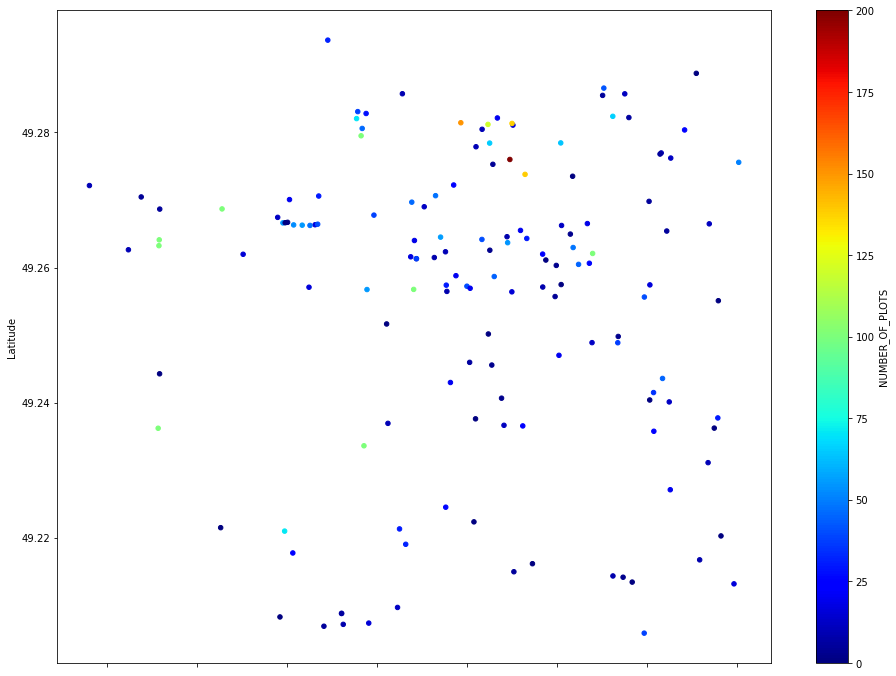

In [70]:
gardenDF.plot(
    kind='scatter',
    x='Longitude',
    y='Latitude',
    c='NUMBER_OF_PLOTS',
    cmap='jet'
)           

Once you have an idea of what your data source looks like there are some arguments to `read_csv` (and related functions) which can tidy things up as they are loaded

In [71]:
import json

def geom2lat(geom):
    if geom:
        return json.loads(geom)['coordinates'][0]
    else:
        return np.NaN

    
gardenDF = pd.read_csv(
    "https://opendata.vancouver.ca/explore/dataset/community-gardens-and-food-trees/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B",
    usecols = [
        'MAPID',
        'YEAR_CREATED',
        'NAME',
        'STEWARD_OR_MANAGING_ORGANIZATION',
        'STREET_NUMBER',
        'STREET_NAME',
        'Geom',
        'Geom'
    ],
    delimiter=';',
    encoding='latin1',
    na_values={
        'YEAR_CREATED': ['Pre-2010', 'pre-1970', 'pre 2000', 'nan']
    },
    index_col='MAPID',
    parse_dates=['YEAR_CREATED'],
    converters={
        'Geom': geom2lat,
    }
)
gardenDF.head()

,YEAR_CREATED,NAME,STREET_NUMBER,STREET_NAME,STEWARD_OR_MANAGING_ORGANIZATION,Geom
MAPID,,,,,,
FA001,NaT,0 - Private Developments - Community Shared,NaN,NaN,NaN,NaN
FA006,2011-01-01,Adanac Park Community Garden,1025,Boundary,Adanac Community Garden Society,-123.024395
FA008,NaT,Arbutus Village Park,4202,Valley,NaN,-123.154995
FA013,2012-01-01,Brewery Creek Community Garden,2390,Brunswick,Urban Diggers Society,-123.095733
FA014,NaT,Burrard View Park,650,Penticton,NaN,-123.051918


## Accessing Data via APIs

An API (Application Programming Interface) is a formal specification describing how systems should communicate with each other. This is an incredibly general notion which could involve information going in both directions and changes being made on both systems. We will only talk about them in the context of extracting data and massaging it into pandas, but full featured APIs could also support authentication, uploading information, telling AWS to shutdown all your ec2 instances or pretty much anything else you could think of.

APIs allow applications (you're code) to interact with other applications (someone elses' code) and they're particularly useful where the incoming data is event based or otherwise frequently updated. They also turn up in situations where the entire data set is very large, but individual requests will only need small slices; applications can request the information they need on demand without the source having to pre-prepare all the possible variations for download.

Good APIs are versioned (or at the very least stable), well documented and they often implement a pattern called [REST](https://en.wikipedia.org/wiki/Representational_state_transfer). This adds a layer of formality and standardization to the API which which helps to make them more predictable and easier to develop against. Most of the API's I can think of operate over HTTP and pass information back and forth in the [json](https://en.wikipedia.org/wiki/JSON) format.


For popular APIs (e.g. [twitter](https://developer.twitter.com/en/docs/twitter-api)) you might find that someone has already written a python wrapper for the API (e.g [python-twitter](https://python-twitter.readthedocs.io/en/latest/)). This is usually the best case scenario because it means someone else has done the hard work of reading the API specification for you. In other cases, you might only have access to the API spec or maybe a console to help you build queries. If you're very unlucky, the API will be undocumented, the silver lining in this case is these are usually where the really juicy stuff is stored!

* [Vancouver Open Data Portal](https://opendata.vancouver.ca/api/v1/console/datasets/1.0/search/) has a console to help you build queries
* [Canada Open Data Portal](https://open.canada.ca/en/working-data#toc93c) has instructions on interfacing with python
* [Stats Canada API](https://www.statcan.gc.ca/eng/developers/wds/user-guide#a12-3) See also [this post](https://towardsdatascience.com/how-to-collect-data-from-statistics-canada-using-python-db8a81ce6475) on using that portal
* [Twitter API](https://developer.twitter.com/en/docs)
* [Open Weather Map](https://openweathermap.org/api)
* [NASA](https://api.nasa.gov/) imagery, data, etc.
* [GitHub](https://docs.github.com/en/rest)

If there isn't a pre-packaged module to take care of your needs the [requests module](https://docs.python-requests.org/en/master/) is usually your best option. Here is a quick example extracting the part of the gardens dataset from the vancouver data portal

In [72]:
import requests

url = 'https://opendata.vancouver.ca/api/v2/catalog/datasets/community-gardens-and-food-trees/records'
headers = {
 'Content-Type': 'application/json; charset=utf-8'
}


params = {
    'dataset_id' : 'community-gardens-and-food-trees',
    'limit'      : 10,
    'facet'      : 'jurisdiction',
    'refine'     : 'jurisdiction:City'
}


r = requests.get(url, params=params)
r.status_code

200

In [73]:
r.headers['content-type']

'application/json; charset=utf-8'

In [74]:
r.json();

If you look up these params in the the [API documentation](https://opendata.vancouver.ca/api/v2/console#!/dataset/getRecords) you'll see that we are filtering for records where `jurisdiction` is `City` and we are asking for a `limit` of 10 records (which is actually the default value of `limit`). But there are 24 records in total which match that filter (look at the first line of `r.json()`. If we want them all, we have to access them in pages. Before we do that though, we should think about rate limits. Almost every API will implement some form of rate limit and the Vancouver Open Data (as well as a lot of other places) will tell you what your current rate limit status is in the response headers.

In [75]:
{k:v for k, v in dict(r.headers).items() if k.startswith('X-Rate')}

{'X-RateLimit-Remaining': '14996',
 'X-RateLimit-Limit': '15000',
 'X-RateLimit-Reset': '2022-07-13 00:00:00+00:00'}

[Their documentation](https://help.opendatasoft.com/apis/ods-search-v1/#quotas) has information on these values. In general, registered users will be given more generous limits. Often this means registering for some kind of token and including it in your requests, we will do this below, but with one **major** caveat. The token is usually equivalent to a password and you should treat it the same way. Don't share it with people, be careful where you use it (including jupyter notebook output cells!), and make sure you don't check it into version control!

In [76]:
import os
from getpass import getpass

In [77]:
os.environ['VAN_API_KEY'] = getpass('API Key')

In [78]:
params['apikey'] = os.environ['VAN_API_KEY']
r = requests.get(url, params=params)

In [79]:
{k:v for k, v in dict(r.headers).items() if k.startswith('X-Rate')}

{'X-RateLimit-Remaining': '14995',
 'X-RateLimit-Limit': '15000',
 'X-RateLimit-Reset': '2022-07-13 00:00:00+00:00'}

With our new rate limit we can make multiple requests and get all of the data we wanted. Even so it is worth limiting the impact we will have on their API, there are modules like [ratelimit](https://pypi.org/project/ratelimit/) which can do this systematically, but we will just add a manual delay.

In [80]:
import time
from urllib.parse import urlencode, urljoin

records = []
url  = f"{url}?{urlencode(params)}"

while True:
    time.sleep(2)
    
    r = requests.get(url)
    urls = {x['rel']:x['href'] for x in r.json()['links']}

    records.extend(r.json()['records'])
    
    if urls['self'] == urls['last']:
        break
    else:
        url = urls['next']
        params = {}

In [81]:
len(records)

24

## TimeSeries

We've already talked about time and date handling a bit, but I use this a lot, so we can talk about it more! Pandas was created to handle Financial data and do financial modeling. This lineage has given pandas really excellent time handling. The main objects are

  * **Time Stamps**: Specific points in time usually recorded to the second or nanosecond
  * **Time Intervals/Time Deltas**: These types lets you do arithmetic on time objects

We need some dates to play with. There's a convenience function called `to_datetime` which can convert many "human readable" dates to a pd.Timestamp object

In [82]:
from datetime import datetime

moonwalk = pd.to_datetime('July 20, 1969, 20:17 UTC')
moonwalk

Timestamp('1969-07-20 20:17:00+0000', tz='UTC')

Timestamps have attributes which let you extract days, year, etc. Normally these will be reported as numbers, but the strftime method supports the usual format specifiers (The correspond with the libc specifiers, here's a reference http://strftime.org/)

In [83]:
print(f"The moon walk took place on a {moonwalk.strftime('%A')}")

The moon walk took place on a Sunday


In [84]:
pd.to_datetime(datetime.utcnow(), utc=True)

Timestamp('2022-07-12 16:30:38.020518+0000', tz='UTC')

Let's look at another sample dataset. This time, it is a record of historical flight data. It contains various columns, we will look at

  * `activity_period`: The date for the record in the format yyyymm
  * `passenger_count`: Total passengers flying in that period
  
We can parse the date into a DateTime with `pd.to_datetime` then set the result as the index. We can then slice dates and resample

In [85]:
import requests

In [86]:
r = requests.get('https://data.sfgov.org/resource/rkru-6vcg?$limit=10000')

flightsDF = pd.DataFrame(r.json())
flightsDF.head()

,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
0,202106,Lufthansa German Airlines,LH,Lufthansa German Airlines,LH,International,Europe,Deplaned,Other,International,G,3336
1,202106,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Enplaned,Other,Terminal 2,D,3626
2,202106,United Airlines,UA,United Airlines,UA,Domestic,US,Thru / Transit,Other,Terminal 3,F,144
3,202106,Jazz Aviation,QK,Air Canada,AC,International,Canada,Deplaned,Other,International,G,1669
4,202106,TAP Air Portugal,TP,TAP Air Portugal,TP,International,Europe,Enplaned,Other,International,G,1923


In [87]:
flightsDF.dtypes

activity_period                object
operating_airline              object
operating_airline_iata_code    object
published_airline              object
published_airline_iata_code    object
geo_summary                    object
geo_region                     object
activity_type_code             object
price_category_code            object
terminal                       object
boarding_area                  object
passenger_count                object
dtype: object

In [88]:
flightsDF['passenger_count'] = flightsDF['passenger_count'].astype(int)
flightsDF['date'] = pd.to_datetime(flightsDF['activity_period'], format='%Y%m')

flightsDF.set_index('date', inplace=True)
flightsDF.head()

,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,terminal,boarding_area,passenger_count
date,,,,,,,,,,,,
2021-06-01,202106,Lufthansa German Airlines,LH,Lufthansa German Airlines,LH,International,Europe,Deplaned,Other,International,G,3336
2021-06-01,202106,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Enplaned,Other,Terminal 2,D,3626
2021-06-01,202106,United Airlines,UA,United Airlines,UA,Domestic,US,Thru / Transit,Other,Terminal 3,F,144
2021-06-01,202106,Jazz Aviation,QK,Air Canada,AC,International,Canada,Deplaned,Other,International,G,1669
2021-06-01,202106,TAP Air Portugal,TP,TAP Air Portugal,TP,International,Europe,Enplaned,Other,International,G,1923


You can resample data into different time periods. E.g. here we resample monthly, summing the values in each month

In [89]:
monthlyFlightsDF = flightsDF.resample('M').sum()
monthlyFlightsDF.head()

,passenger_count
date,
2018-03-31,3745874
2018-04-30,9426366
2018-05-31,10051190
2018-06-30,10854288
2018-07-31,11385144


<AxesSubplot:xlabel='date'>

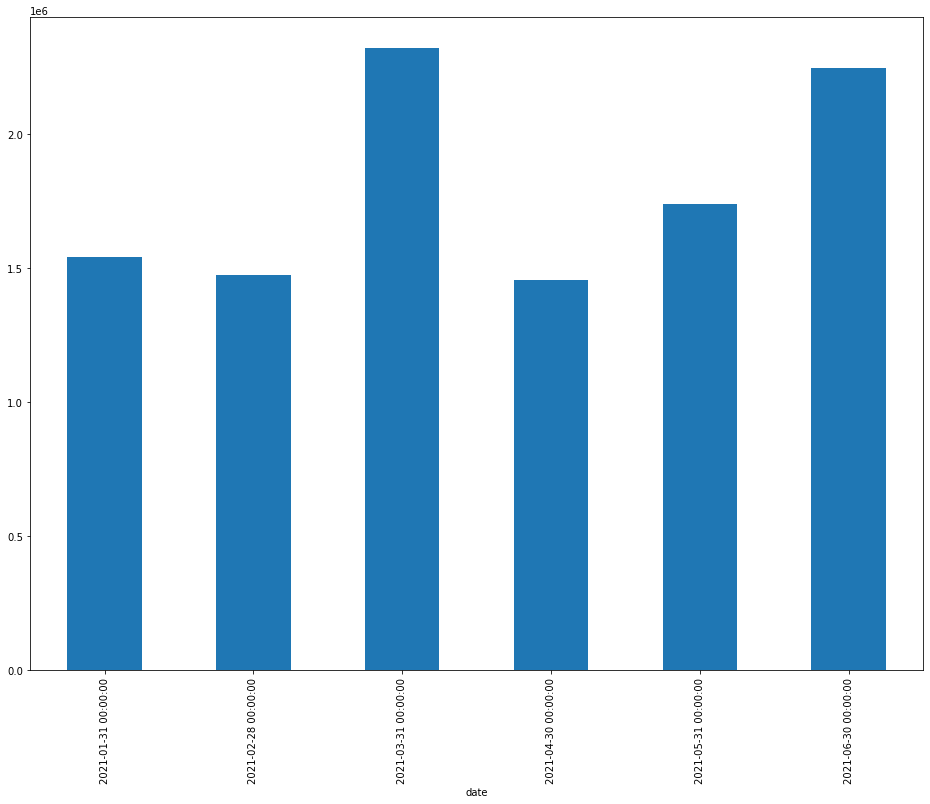

In [90]:
monthlyFlightsDF.loc['2021-01-01':, 'passenger_count'].plot(kind='bar')

Timestamp objects can also deal with arithmetic

In [91]:
flightsDF.index[-1] - flightsDF.index[0]

Timedelta('-1188 days +00:00:00')

<AxesSubplot:xlabel='date'>

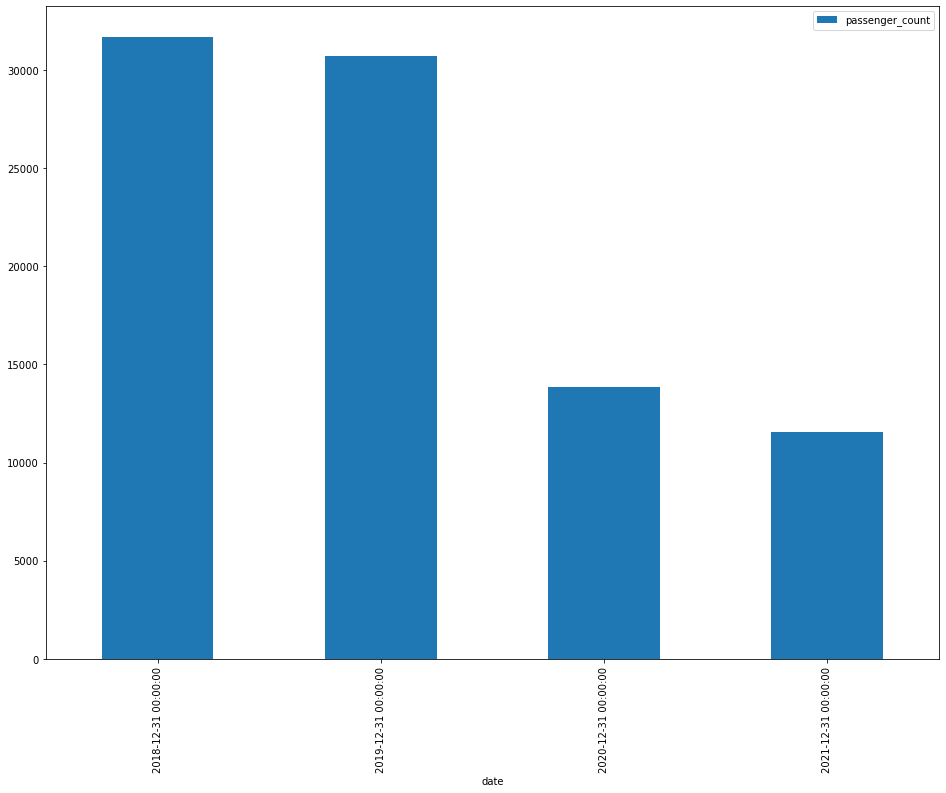

In [92]:
flightsDF.resample('Y').mean().plot(kind='bar')

As an aside, this dataset has quite a few categorical variables (`dtype== object`). Modules like `sklearn` will normally want to deal with purely numerical values. `sklearn` has it's own tools for doing this sort of transform, but pandas can also do it at a lower level 

In [93]:
categorical_cols = [col for col in flightsDF.columns if flightsDF[col].dtype =='object']
categorical_cols

['activity_period',
 'operating_airline',
 'operating_airline_iata_code',
 'published_airline',
 'published_airline_iata_code',
 'geo_summary',
 'geo_region',
 'activity_type_code',
 'price_category_code',
 'terminal',
 'boarding_area']

The `value_counts` method can be very useful to get an idea of how categorical values are distributed...

In [94]:
flightsDF['geo_region'].value_counts()

US                     3012
Europe                 2109
Asia                   2057
Canada                  810
Mexico                  752
Australia / Oceania     672
Middle East             312
Central America         276
Name: geo_region, dtype: int64

In [95]:
airlines_one_hot = pd.get_dummies(flightsDF['geo_region'])
flightsDF = flightsDF.drop('geo_region',axis = 1)
flightsDF.join(airlines_one_hot).head()

,activity_period,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,activity_type_code,price_category_code,terminal,boarding_area,passenger_count,Asia,Australia / Oceania,Canada,Central America,Europe,Mexico,Middle East,US
date,,,,,,,,,,,,,,,,,,,
2018-03-01,201803,ABC Aerolineas S.A. de C.V. dba Interjet,4O,ABC Aerolineas S.A. de C.V. dba Interjet,4O,International,Deplaned,Other,International,A,1090,0,0,0,0,0,1,0,0
2018-03-01,201803,ABC Aerolineas S.A. de C.V. dba Interjet,4O,ABC Aerolineas S.A. de C.V. dba Interjet,4O,International,Deplaned,Other,International,A,1090,0,0,0,0,0,1,0,0
2018-03-01,201803,ABC Aerolineas S.A. de C.V. dba Interjet,4O,ABC Aerolineas S.A. de C.V. dba Interjet,4O,International,Deplaned,Other,International,A,1090,0,0,0,0,1,0,0,0
2018-03-01,201803,ABC Aerolineas S.A. de C.V. dba Interjet,4O,ABC Aerolineas S.A. de C.V. dba Interjet,4O,International,Deplaned,Other,International,A,1090,0,0,0,0,1,0,0,0
2018-03-01,201803,ABC Aerolineas S.A. de C.V. dba Interjet,4O,ABC Aerolineas S.A. de C.V. dba Interjet,4O,International,Deplaned,Other,International,A,1090,0,0,0,0,0,1,0,0


## Grouping, Joining, Concatenating

You can get pretty far by jamming everything into a single dataframe, but sometimes you might want to do aggregate operations within a dataframe (e.g. group together all of the rows by year and show the mean value of some other column). Alternatively you might want to add new rows to or columns to an existing DataFrame or join dataframes based on shared key.


Another dataset...

In [96]:
carsDF = pd.read_csv(
    'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'
)
carsDF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


### Groupby
Let's group things by number_of_cylinders and see how that affects mpg...

In [97]:
carsDF['mpg'].mean()

23.514572864321615

Calling `groupby` on it's own will give you a `DataFrameGroupBy` object, informally you can think of this as a collection of Dataframes with subsets of the original Dataframe grouped together based on your condition. You can then perform aggregate operations (e.g. `sum`, `mean` etc.) on these groups to actually see some results.

In [98]:
carsDFbyCylinders = carsDF.groupby('cylinders')
carsDFbyCylinders

The typical aggregate operations are things like

  * mean()
  * sum()
  * median()
  * min()/max()

In [99]:
carsDFbyCylinders.mean()

,mpg,displacement,horsepower,weight,acceleration,model_year
cylinders,,,,,,
3,20.550000,72.500000,99.250000,2398.500000,13.250000,75.500000
4,29.286765,109.796569,78.281407,2308.127451,16.601471,77.073529
5,27.366667,145.000000,82.333333,3103.333333,18.633333,79.000000
6,19.985714,218.142857,101.506024,3198.226190,16.263095,75.928571
8,14.963107,345.009709,158.300971,4114.718447,12.955340,73.902913


The `agg` method lets you apply arbitrary aggregate functions as well, e.g.

In [100]:
carsDFbyCylinders['mpg'].agg(np.std)

cylinders
3    2.564501
4    5.710156
5    8.228204
6    3.807322
8    2.836284
Name: mpg, dtype: float64

Group the carsDF by model_year and look at the median mpg (don't include the other columns)

In [101]:
carsDF.groupby('model_year')['mpg'].median()

model_year
70    16.00
71    19.00
72    18.50
73    16.00
74    24.00
75    19.50
76    21.00
77    21.75
78    20.70
79    23.90
80    32.70
81    31.60
82    32.00
Name: mpg, dtype: float64

You can actually do much more with groupby, you can iterate over the groups

In [102]:
for cylinders, group in carsDFbyCylinders:
    print(f"There are {group.shape[0]} cars with {cylinders} cylinders")

There are 4 cars with 3 cylinders
There are 204 cars with 4 cylinders
There are 3 cars with 5 cylinders
There are 84 cars with 6 cylinders
There are 103 cars with 8 cylinders


How are there possibly 4 cars with 3 cylinders?!

We can apply multiple operations at the same time. The `.aggregate()` method can take a list of the operations you want to perform (e.g. ["max", "min"])

In [103]:
carsDFbyCylinders['mpg'].aggregate(["min","max","mean"])

,min,max,mean
cylinders,,,
3,18.0,23.7,20.550000
4,18.0,46.6,29.286765
5,20.3,36.4,27.366667
6,15.0,38.0,19.985714
8,9.0,26.6,14.963107


We can filter based on group, this is a silly example, but group the cars by cylinder, then show me all of the groups with a mean mpg > 15.

In [104]:
carsDFbyCylinders.filter(lambda x: x['mpg'].mean()>15).head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
14,24.0,4,113.0,95.0,2372,15.0,70,japan,toyota corona mark ii
15,22.0,6,198.0,95.0,2833,15.5,70,usa,plymouth duster
16,18.0,6,199.0,97.0,2774,15.5,70,usa,amc hornet
17,21.0,6,200.0,85.0,2587,16.0,70,usa,ford maverick
18,27.0,4,97.0,88.0,2130,14.5,70,japan,datsun pl510


The transform method lets you perform a group operation then use the results to update the rows. For example, we could calculate mean values for our groups, then look at how individual cars perform relative to that

In [105]:
carsDF['mpg_mean'] = carsDFbyCylinders['mpg'].transform(lambda x: x - x.mean())

So we could look at the best and worst performing car relative to the group means, `idxmin` and `idxmax` are to pandas as `argmin` and `argmax` are to numpy (see also `nlargest`).

In [106]:
carsDF.loc[carsDF.groupby('cylinders')['mpg_mean'].idxmax()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,mpg_mean
334,23.7,3,70.0,100.0,2420,12.5,80,japan,mazda rx-7 gs,3.150000
322,46.6,4,86.0,65.0,2110,17.9,80,japan,mazda glc,17.313235
327,36.4,5,121.0,67.0,2950,19.9,80,europe,audi 5000s (diesel),9.033333
387,38.0,6,262.0,85.0,3015,17.0,82,usa,oldsmobile cutlass ciera (diesel),18.014286
364,26.6,8,350.0,105.0,3725,19.0,81,usa,oldsmobile cutlass ls,11.636893


In [107]:
carsDF.loc[carsDF.groupby('cylinders')['mpg_mean'].idxmin()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,mpg_mean
111,18.0,3,70.0,90.0,2124,13.5,73,japan,maxda rx3,-2.550000
76,18.0,4,121.0,112.0,2933,14.5,72,europe,volvo 145e (sw),-11.286765
274,20.3,5,131.0,103.0,2830,15.9,78,europe,audi 5000,-7.066667
128,15.0,6,250.0,100.0,3336,17.0,74,usa,chevrolet nova,-4.985714
28,9.0,8,304.0,193.0,4732,18.5,70,usa,hi 1200d,-5.963107


The 3 cylinder engines are rotaries!

You can also group by multiple conditions, but you'll get a hierarchical index as the result

In [108]:
carsDF.groupby(['origin', 'cylinders']).mean()

mpg  displacement  horsepower       weight  \
origin cylinders                                                     
europe 4          28.411111    104.222222   78.311475  2330.015873   
       5          27.366667    145.000000   82.333333  3103.333333   
       6          20.100000    159.750000  113.500000  3382.500000   
japan  3          20.550000     72.500000   99.250000  2398.500000   
       4          31.595652     99.768116   75.579710  2153.492754   
       6          23.883333    156.666667  115.833333  2882.000000   
usa    4          27.840278    124.284722   80.956522  2437.166667   
       6          19.663514    226.283784   99.671233  3213.905405   
       8          14.963107    345.009709  158.300971  4114.718447   

                  acceleration  model_year      mpg_mean  
origin cylinders                                          
europe 4             16.722222   75.507937 -8.756536e-01  
       5             18.633333   79.000000  2.368476e-15  
       6             16.425000   78.250000  1.142857e-01  
japan  3             13.250000   75.500000 -8.881784e-16  
       4             16.569565   77.507246  2.308887e+00  
       6             13.550000   78.000000  3.897619e+00  
usa    4             16.526389   78.027778 -1.446487e+00  
       6             16.474324   75.635135 -3.222008e-01  
       8             12.955340   73.902913 -2.811128e-15

We won't cover Hierarchical indices, so for now we will just flatten the result by resetting the index

In [109]:
carsDF.groupby(['origin', 'cylinders'])['mpg'].mean().reset_index()

,origin,cylinders,mpg
0,europe,4,28.411111
1,europe,5,27.366667
2,europe,6,20.100000
3,japan,3,20.550000
4,japan,4,31.595652
5,japan,6,23.883333
6,usa,4,27.840278
7,usa,6,19.663514
8,usa,8,14.963107


There is also an `apply` method which can work on the entire DataFrame _at the same time_, this can be useful. N.B. `.transform` and `.apply` exist as methods of both ordinary DataFrames and `DataFrameGroupBy` objects, depending on what you want to do.

## Concatenate & Join

There are a handful of functions which handle concatenation. The main ones are `pd.concat`, `pd.join` and `pd.merge` and there is some overlap in exactly what they do so. You can combine either `Series` and `DataFrames` but we'll jump straight to `DataFrames`,

In [110]:
s1 = pd.DataFrame(
    {
        'upper': ['A', 'B', 'C'], 
        'lower': ['a', 'b', 'c']
    }, 
    columns=['upper', 'lower'], 
    index=[1,2,3]
)

s2 = pd.DataFrame(
    {
        'upper': ['D', 'E', 'F'],
        'lower': ['d', 'e', 'f']
    }, 
    columns=['upper', 'lower'],
    index=[1, 2, 3]
)
s2

,upper,lower
1,D,d
2,E,e
3,F,f


`pd.join` will combine by aligning on the index, but expects unique column names, we can use the suffix keyword to make our columns unique

In [111]:
s1.join(s2, lsuffix='l_', rsuffix='r_')

,upperl_,lowerl_,upperr_,lowerr_
1,A,a,D,d
2,B,b,E,e
3,C,c,F,f


With `concat` we can combine rows (we'll reindex to get unique index values in the result)

In [112]:
pd.concat([s1,s2]).reset_index()

,index,upper,lower
0,1,A,a
1,2,B,b
2,3,C,c
3,1,D,d
4,2,E,e
5,3,F,f


Notice that we enclosed the things we want to join as some sort of iterable (a `list` here).

`concat` can also combine columns with some work

In [113]:
pd.concat([s1, s2], axis='columns')

,upper,lower,upper,lower
1,A,a,D,d
2,B,b,E,e
3,C,c,F,f


`pd.concat` will accept duplicate indices, but normally that indicates a problem with the data normalization. `concat` has a `verify_index` argument which can check for these problems and you can specify what you want to do with duplicates manually.

`concat` will often result in `NaN`s because some columns might not exist in both/all frames.

In [114]:
d4 = pd.DataFrame({'fruit': ['apple', 'orange'], 'veg': ['brocolli', 'carrot'], 'tree': ['cedar', 'alder']})
d5 = pd.DataFrame({'veg': ['onion', 'potato'], 'fruit': ['banana','grape']})
pd.concat([d4,d5], sort=False, ignore_index=True)

,fruit,veg,tree
0,apple,brocolli,cedar
1,orange,carrot,alder
2,banana,onion,NaN
3,grape,potato,NaN


Since the index wasn't important here, I threw it away and just accepted a new one.

In the general case, joining DataFrames can get complex. The concat method can take a `join` keyword to specify a database like join stragegy (inner or outer), but `pd.merge` is a bit more flexible. It implements the usual relations

  * one-to-one (similar to a concat)
  * many-to-one
  * many-to-many
  
For the many-to-one case here is an example

In [115]:
adf1=pd.DataFrame({
    'class': ['insect', 'spider'], 
    'legs': [6, 8]}
)

adf2=pd.DataFrame({
    'name': ['molly', 'anna', 'stephen', 'mica'], 
    'class': ['insect','insect','spider','insect']}
)                     

print(adf1); print(adf2)

    class  legs
0  insect     6
1  spider     8
      name   class
0    molly  insect
1     anna  insect
2  stephen  spider
3     mica  insect


In [116]:
pd.merge(adf1, adf2)

,class,legs,name
0,insect,6,molly
1,insect,6,anna
2,insect,6,mica
3,spider,8,stephen


The _many-to-one_ is many different rows in adf2 being mapped to a single row in adf1 (insects). `pd.merge` also accepts a selection of keyword arguments so you can manually specify which columns to join, patch up name differences etc.

## Plotting

Pandas uses matplotlib for visualization and I've included a separate notebook on Matplotlib in this repository. Most of what is said in there is accessible with a little bit of effort from within Pandas (as the `.plot` method on Dataframes), or you can use Matplotlib itself explicitlym the choice is yours. The [pandas visualization](https://pandas.pydata.org/docs/user_guide/visualization.html) documentation has more details, and in this section we will show a handful of quick plots

The `.plot` method allows you to create various different kinds of plot by specifying a the kind (either as a keyword argument (e.g. `df.plot(kind='scatter')` or using this syntax `df.plot.scatter()`.) You can do this for

  * `hist`: histograms
  * `bar`: barplots (also barh)
  * `box`: boxplots
  * `kde`: kernel density estimate plots
  * `area`: area plots
  * `scatter`: scatter plots
  * `hexbin`: hexagonal bin plots
  * `pie`: pie charts
  
The default is a simple line plot

<AxesSubplot:title={'center':'Sample plot'}, xlabel='x'>

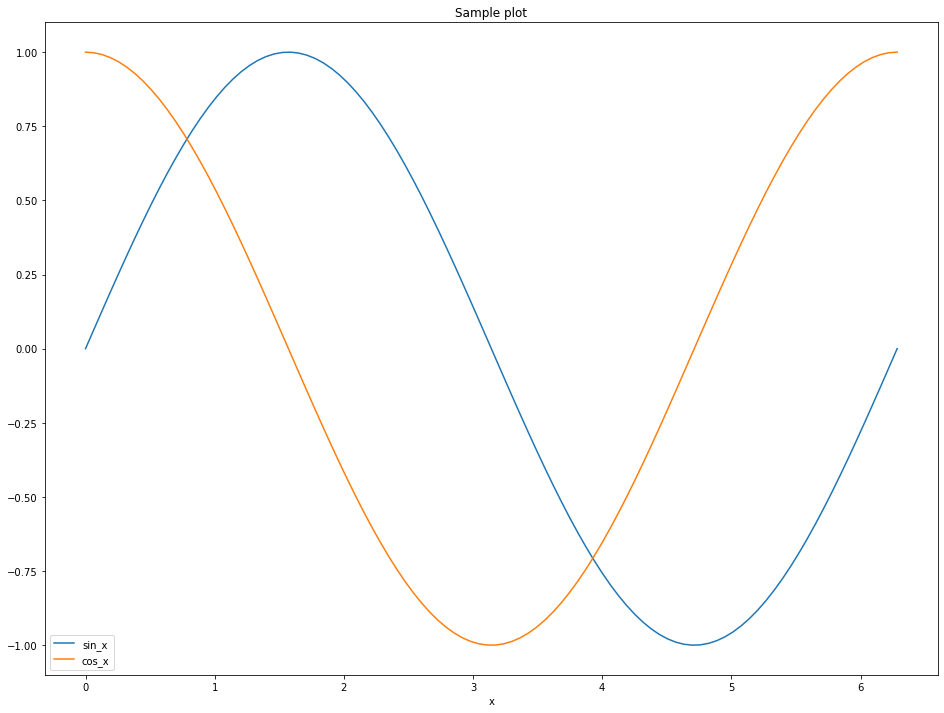

In [117]:
pDF = pd.DataFrame({'x' : np.linspace(0, 2*np.pi, 100)})
pDF[['sin_x','cos_x']] = pDF.apply([np.sin, np.cos])
pDF.plot(
    x='x',
    legend=True,
    title='Sample plot'
)

You can control the output through keywords, e.g. `lw` sets the line width

array([<AxesSubplot:xlabel='x'>, <AxesSubplot:xlabel='x'>], dtype=object)

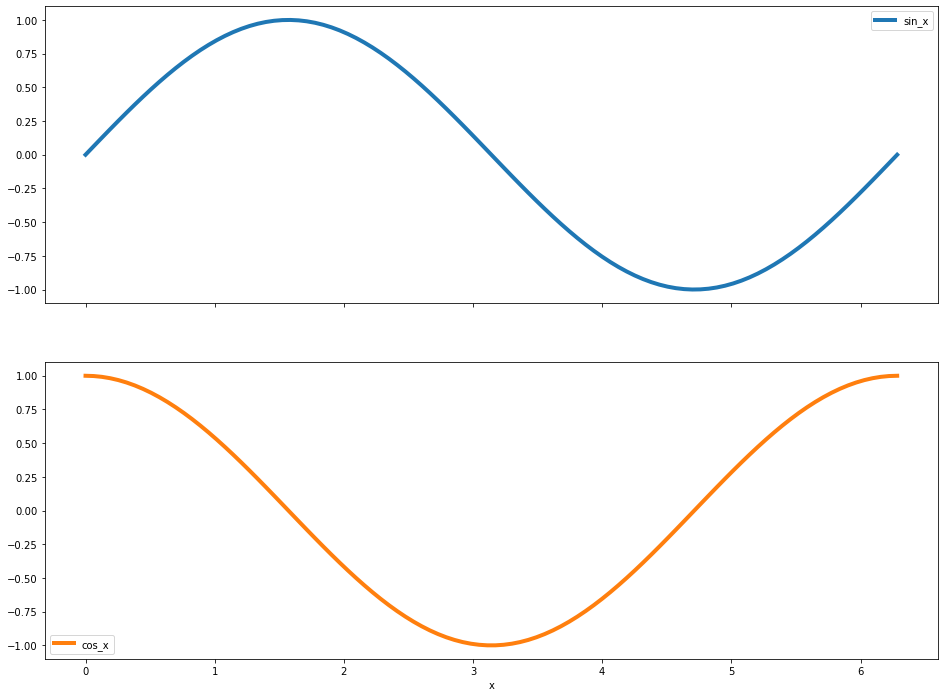

In [118]:
pDF.plot(
    x='x',
    subplots=True,
    lw=4
)

`.plot` returns an axis object (or objects) which you can then adjust with the usual matplotlib manipuations

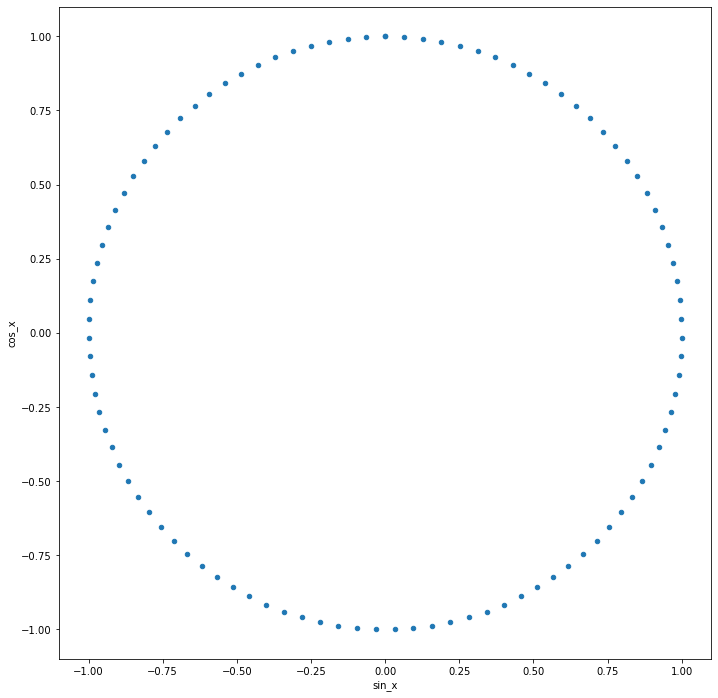

In [119]:
ax = pDF.plot(
    kind='scatter',
    x='sin_x',
    y='cos_x',
)

ax.set_aspect('equal')

In [120]:
csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

# using the attribute information as the column names
col_names = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width','Class']
irisDF =  pd.read_csv(csv_url, names = col_names)

### Histograms

The `hist` kind (or `df.plot.hist`) will select only categorical values by default

<AxesSubplot:ylabel='Frequency'>

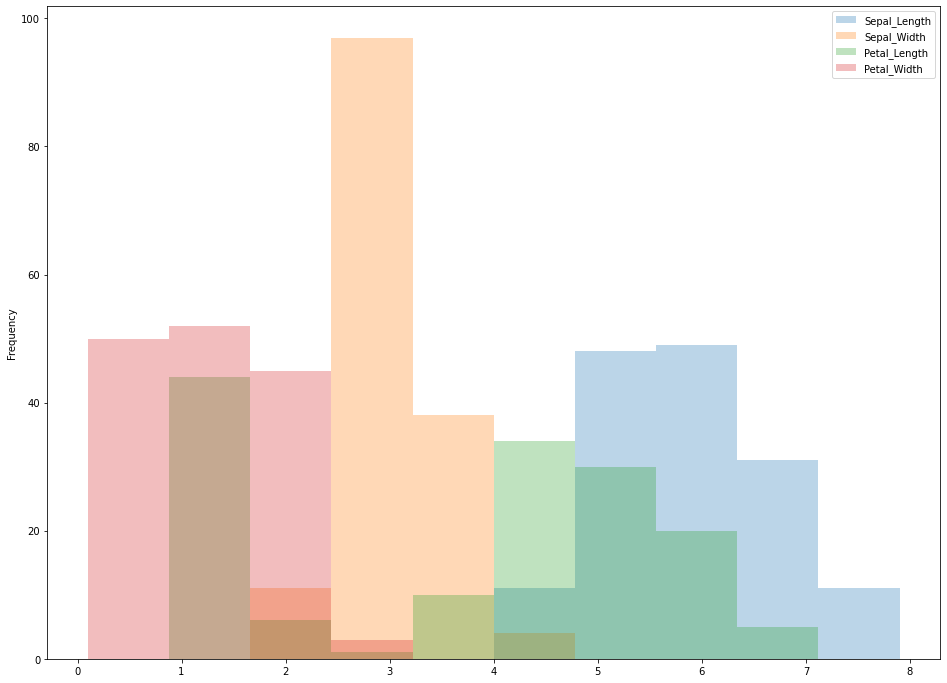

In [121]:
irisDF.plot(
    kind='hist',
    alpha=0.3
)

There is also a hist method on DataFrames which will display each histogram as a subplot

array([[<AxesSubplot:title={'center':'Sepal_Length'}>,
        <AxesSubplot:title={'center':'Sepal_Width'}>],
       [<AxesSubplot:title={'center':'Petal_Length'}>,
        <AxesSubplot:title={'center':'Petal_Width'}>]], dtype=object)

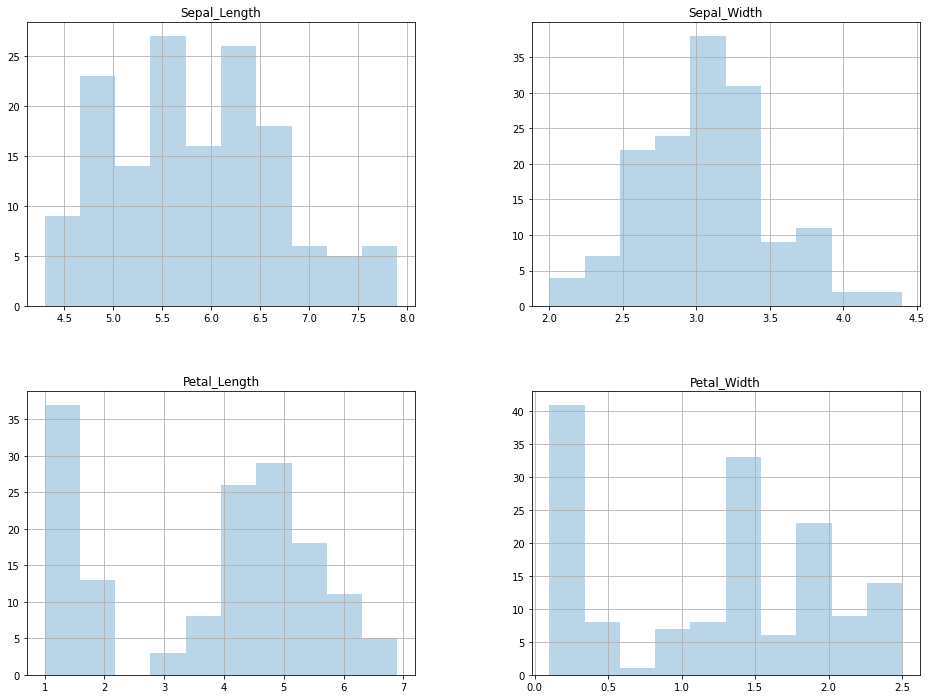

In [122]:
irisDF.hist(alpha=0.3)

### Boxplots

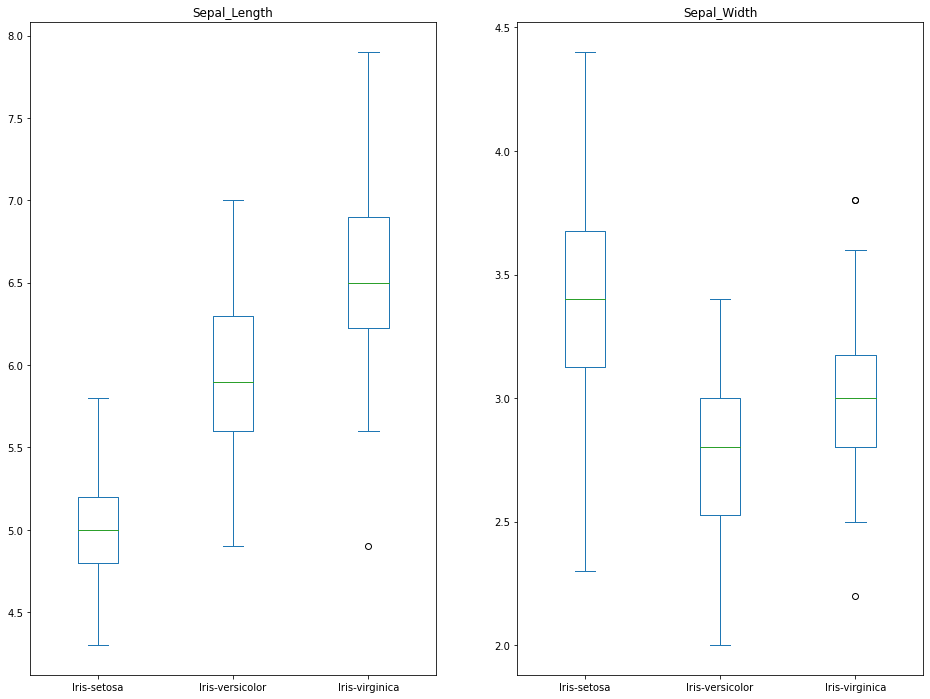

In [123]:
ax = irisDF.plot.box(
    column=['Sepal_Length', 'Sepal_Width'],
    by='Class'
)

## Plotting Utilities

Pandas also includes a handful of very useful functions for exploring common plot combinations. `scatter_matrix` is a good example, it produces a matrix of scatter plots with every numerical feature plotted against every other numerical feature. Since this would be a bit boring down the diagonal, it shows the distribution of values for that variable instead (you can adjust this with e.g. `diagonal='kde'`)

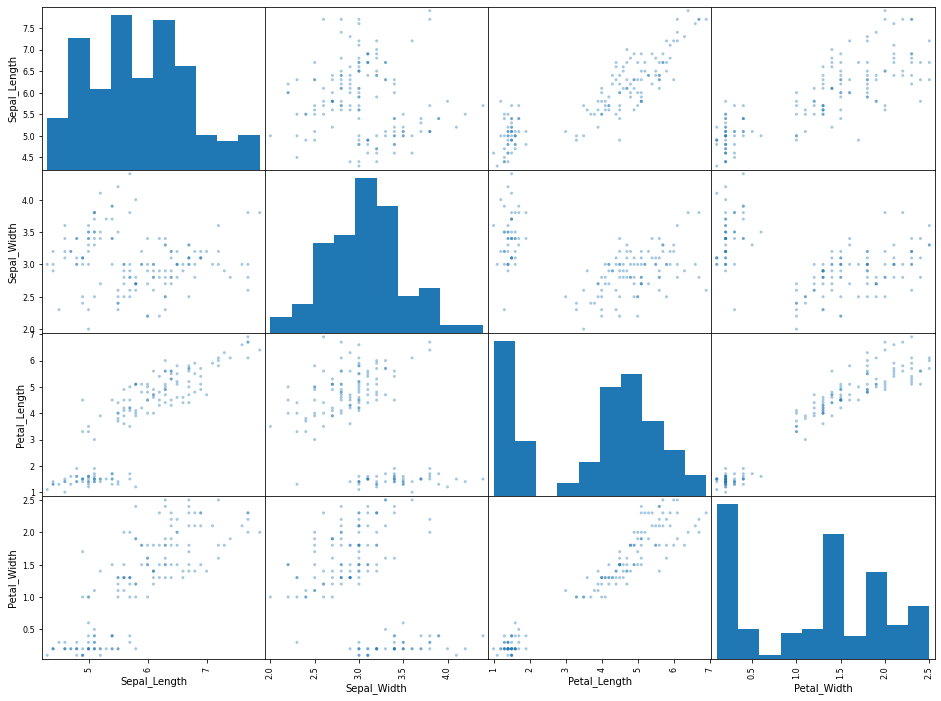

In [124]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(
    irisDF,
    alpha=0.4
)

#### Autocorrelation Plots

For time series, calculating the auto-correlation allows you to see how the data is correlated with itself over various time periods

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

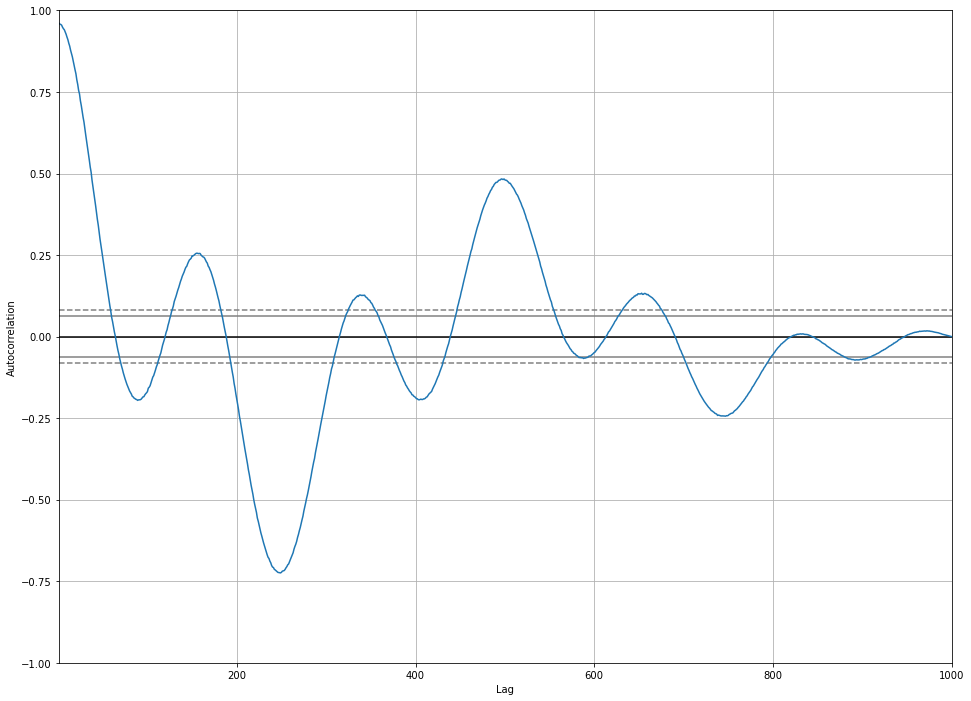

In [125]:
from pandas.plotting import autocorrelation_plot

rng = np.random.default_rng(47)

x = np.linspace(0, 4*np.pi, 1000)

ts = pd.Series(
    (
        np.sin(x + 0.2 * rng.normal(size=x.shape)) + 
        np.cos(3 * x + 0.2 * rng.normal(size=x.shape))
    ),
    index = pd.date_range(
        "1/1/2020",
        periods=1000
    )
)

autocorrelation_plot(ts)